In [4]:
!pip install opencv-python scikit-image matplotlib ultralytics ffmpeg-python

This is a test notebook that intends to show how compression might affect object detection.

## Downloading Dataset

I tested using [Ampulla Pluto DashCam Sample / Night Rain City](https://youtu.be/ZfqXfaB4Qj8?si=UCTtmKaz6fr5puMr), from YouTube. This is a dashcam video on a rainy night, a scenario that might make the task of detection harder, but represents a real-life common situation.

In [2]:
import os
import zipfile
import urllib.request
from google.colab import files

In [5]:
uploaded = files.upload()

for fn in uploaded.keys():
  with open('video.mp4', 'wb') as f:
    f.write(uploaded[fn])
ORIGINAL_VIDEO = f"/content/video.mp4"

Saving Night Rain City.mp4 to Night Rain City (1).mp4


## Compression

In [6]:
frames_dir = {
    "original": "frames/original",
    "h264": "frames/h264",
    "h265": "frames/h265"
}

In [7]:
import ffmpeg

In [8]:
def compress_video(input_path, output_path, codec, crf=23):
    try:
        ffmpeg.input(input_path).output(output_path, vcodec=codec, crf=crf).run(overwrite_output=True)
    except ffmpeg.Error as e:
        print('FFmpeg error:', e.stderr.decode())
        raise

In [9]:
compressed_h264 = "compressed_h264.mp4"
compressed_h265 = "compressed_h265.mp4"
compress_video(ORIGINAL_VIDEO, compressed_h264, "libx264", crf=35)
compress_video(ORIGINAL_VIDEO, compressed_h265, "libx265", crf=35)

## Frame Extraction

In [10]:
import cv2
import matplotlib.pyplot as plt

In [11]:
def extract_frames(video_path, out_dir):
  os.makedirs(out_dir, exist_ok=True)
  cap = cv2.VideoCapture(video_path)
  frame_idx = 0
  while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break
    cv2.imwrite(f"{out_dir}/frame_{frame_idx:04d}.png", frame)
    if frame_idx == 0: #display the first frame
      plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) #convert from BGR to RGB
      plt.show()
    frame_idx += 1
  cap.release()

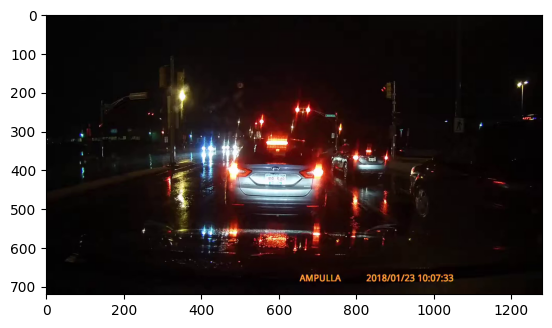

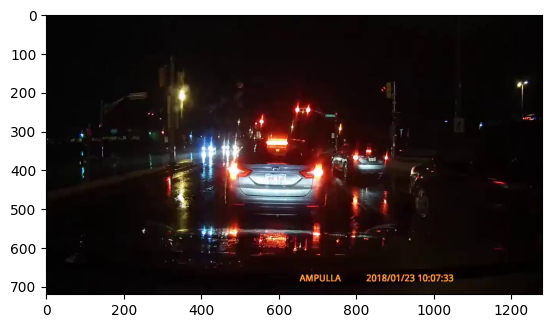

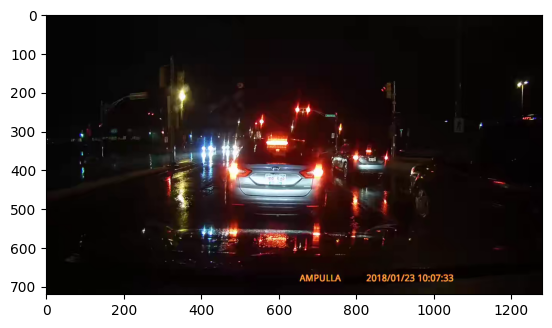

In [12]:
extract_frames(ORIGINAL_VIDEO, "frames/original")
extract_frames(compressed_h264, "frames/h264")
extract_frames(compressed_h265, "frames/h265")

## Object Detection

In [13]:
from ultralytics import YOLO

In [14]:
frame_count = 10  # Number of frames to process
model = YOLO("yolov8n.pt")

In [15]:
def get_image_paths(base_path, count):
    return [os.path.join(base_path, f"frame_{i:04d}.png") for i in range(count)]

In [16]:
def run_detection(image_path):
  result = model(image_path)
  return result[0].boxes.xyxy.cpu().numpy()

In [17]:
boxes = run_detection("frames/original/frame_0000.png") # Test on one frame


image 1/1 /content/frames/original/frame_0000.png: 384x640 4 cars, 199.8ms
Speed: 9.5ms preprocess, 199.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


## Artifact Visualization

In [18]:
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import numpy as np

In [19]:
def compute_metrics(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    ssim_score, ssim_map = ssim(img1, img2, full=True, channel_axis=2)
    psnr_score = psnr(img1, img2)
    return ssim_score, psnr_score, (ssim_map * 255).astype("uint8")

In [20]:
def draw_boxes(img, boxes, color=(0, 255, 0)):
    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    return img

In [21]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [22]:
def compare_detections(original_boxes, compressed_boxes, iou_threshold=0.5):
    matched = np.zeros(len(compressed_boxes), dtype=bool)
    new_boxes, missing_boxes = [], []

    for obox in original_boxes:
        found = False
        for i, cbox in enumerate(compressed_boxes):
            if matched[i]: continue
            iou_val = compute_iou(obox, cbox)
            if iou_val >= iou_threshold:
                matched[i] = True
                found = True
                break
        if not found:
            missing_boxes.append(obox)

    for i, cbox in enumerate(compressed_boxes):
        if not matched[i]:
            new_boxes.append(cbox)

    return new_boxes, missing_boxes

In [23]:
results = {"h264": [], "h265": []}

In [24]:
for i in range(frame_count):
    orig_path = get_image_paths(frames_dir["original"], frame_count)[i]
    orig_img = cv2.imread(orig_path)
    orig_boxes = run_detection(orig_path)

    for codec in ["h264", "h265"]:
        comp_path = get_image_paths(frames_dir[codec], frame_count)[i]
        comp_img = cv2.imread(comp_path)
        comp_boxes = run_detection(comp_path)

        ssim_score, psnr_score, ssim_map = compute_metrics(orig_path, comp_path)
        new_boxes, missing_boxes = compare_detections(orig_boxes, comp_boxes)

        # comparison image
        vis_img = draw_boxes(comp_img.copy(), comp_boxes, (0, 255, 0))
        vis_img = draw_boxes(vis_img, new_boxes, (255, 0, 0))     # Blue for new
        vis_img = draw_boxes(vis_img, missing_boxes, (0, 0, 255)) # Red for missing

        results[codec].append({
            "frame": i,
            "ssim": ssim_score,
            "psnr": psnr_score,
            "detection_count": len(comp_boxes),
            "new_boxes": len(new_boxes),
            "missing_boxes": len(missing_boxes),
            "visual": vis_img[..., ::-1],  # BGR to RGB
            "ssim_map": ssim_map
        })


image 1/1 /content/frames/original/frame_0000.png: 384x640 4 cars, 171.3ms
Speed: 6.7ms preprocess, 171.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/h264/frame_0000.png: 384x640 1 car, 152.7ms
Speed: 3.4ms preprocess, 152.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/h265/frame_0000.png: 384x640 1 car, 165.3ms
Speed: 2.5ms preprocess, 165.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/original/frame_0001.png: 384x640 4 cars, 166.8ms
Speed: 3.8ms preprocess, 166.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/h264/frame_0001.png: 384x640 1 car, 150.9ms
Speed: 2.6ms preprocess, 150.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/frames/h265/frame_0001.png: 384x640 1 car, 151.7ms
Speed: 4.2ms preprocess, 151.7ms inference, 1.2ms postprocess per image at

In [1]:
# Show visualizations for a few sample frames (e.g., first 3) for each codec
frames_to_show = [0, 1, 2]


image 1/1 /content/frames/original/frame_0000.png: 384x640 4 cars, 229.5ms
Speed: 4.9ms preprocess, 229.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


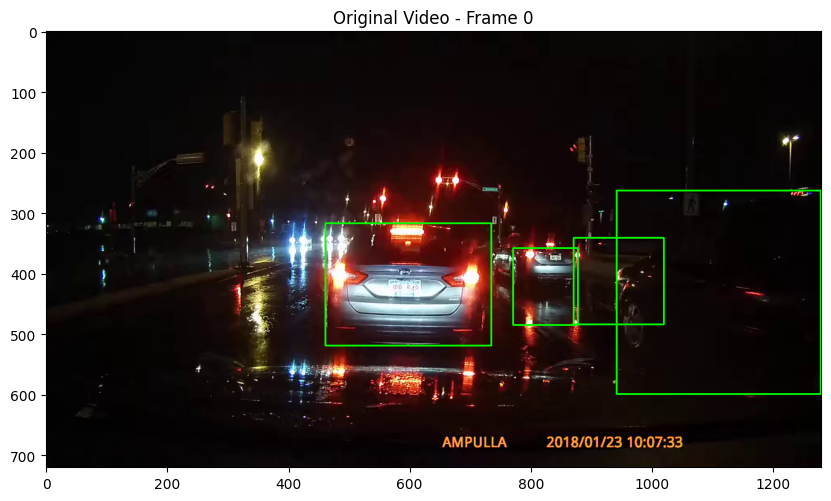


image 1/1 /content/frames/original/frame_0001.png: 384x640 4 cars, 273.1ms
Speed: 7.2ms preprocess, 273.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


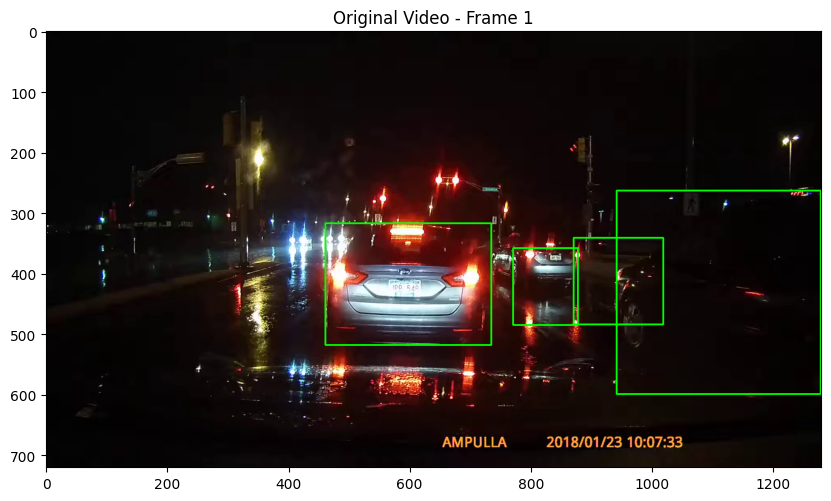


image 1/1 /content/frames/original/frame_0002.png: 384x640 4 cars, 177.9ms
Speed: 3.2ms preprocess, 177.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


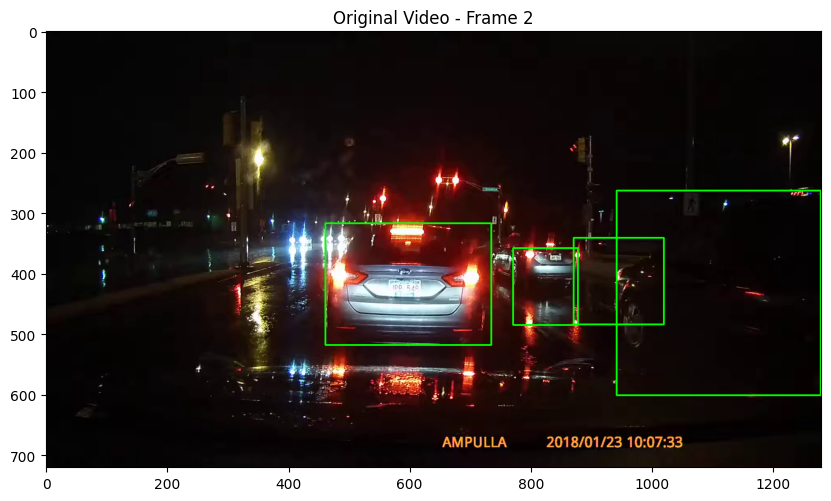

In [26]:
for frame_idx in frames_to_show:
    orig_path = get_image_paths(frames_dir["original"], frame_count)[frame_idx]
    orig_img = cv2.imread(orig_path)
    orig_boxes = run_detection(orig_path)

    vis_img = draw_boxes(orig_img.copy(), orig_boxes)
    plt.figure(figsize=(10, 10))
    plt.imshow(vis_img[..., ::-1])
    plt.title(f"Original Video - Frame {frame_idx}")
    plt.show()


=== Visualizations for H264 ===


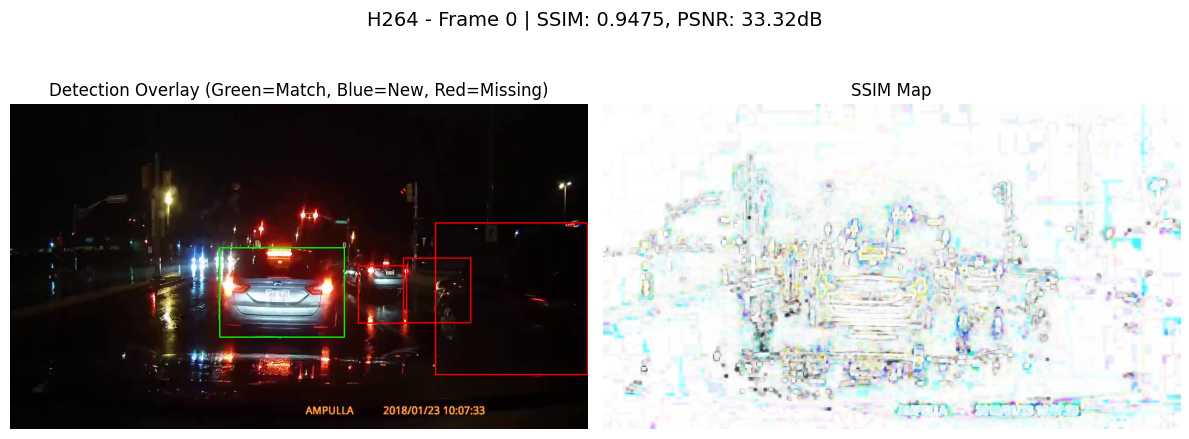

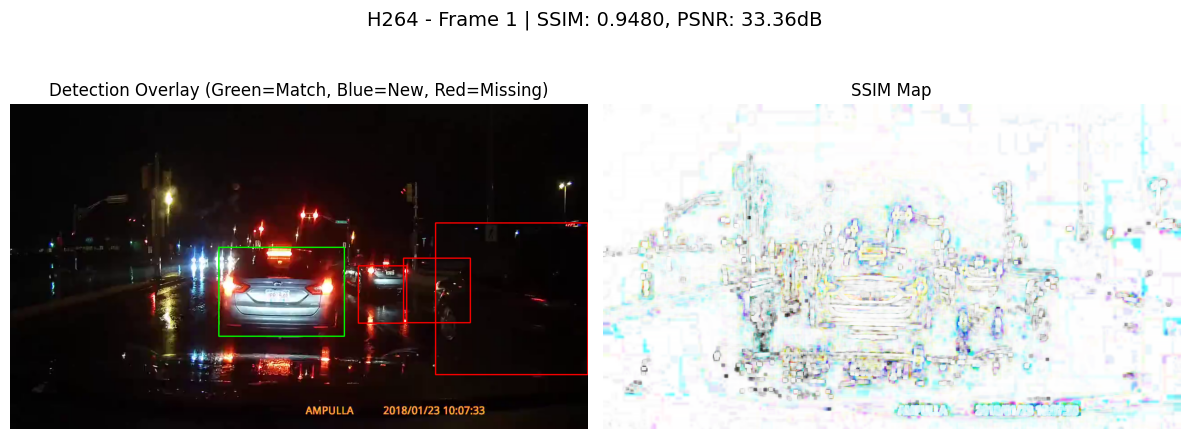

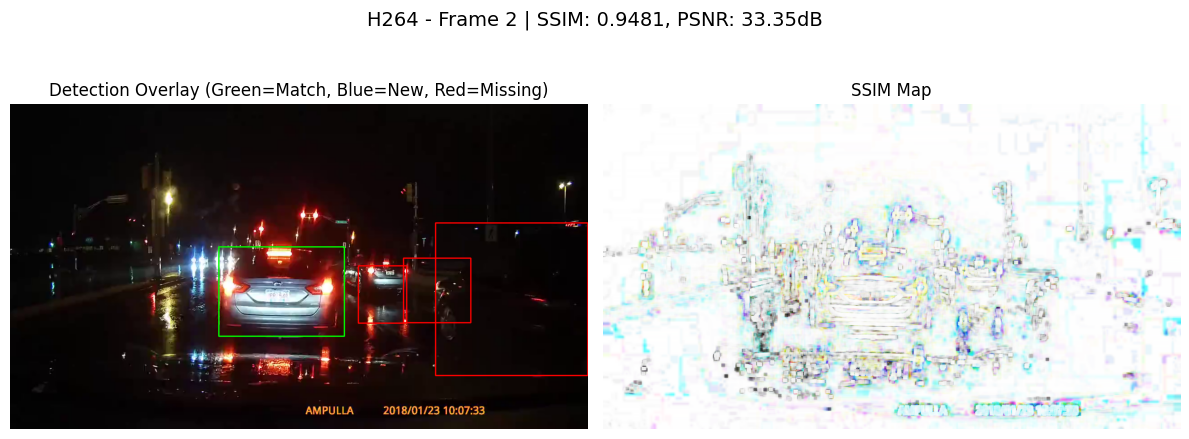


=== Visualizations for H265 ===


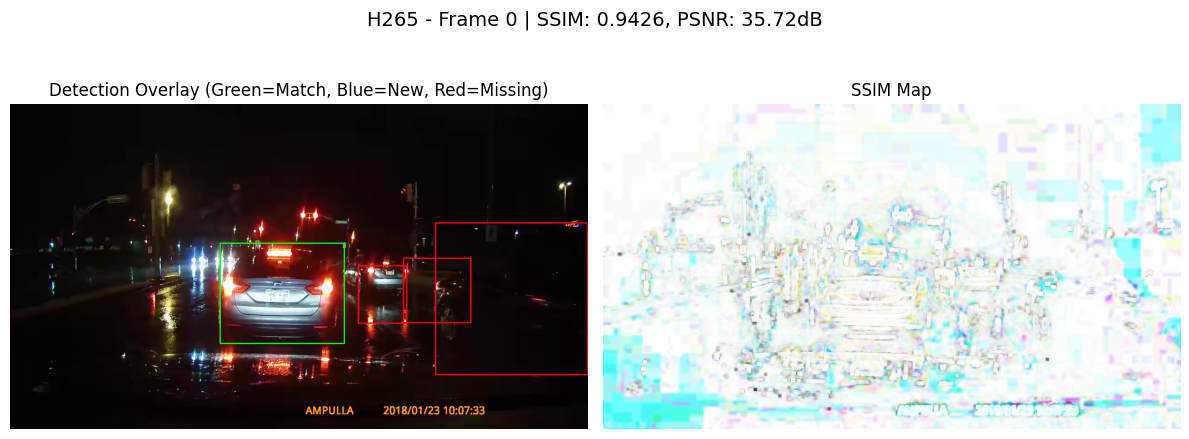

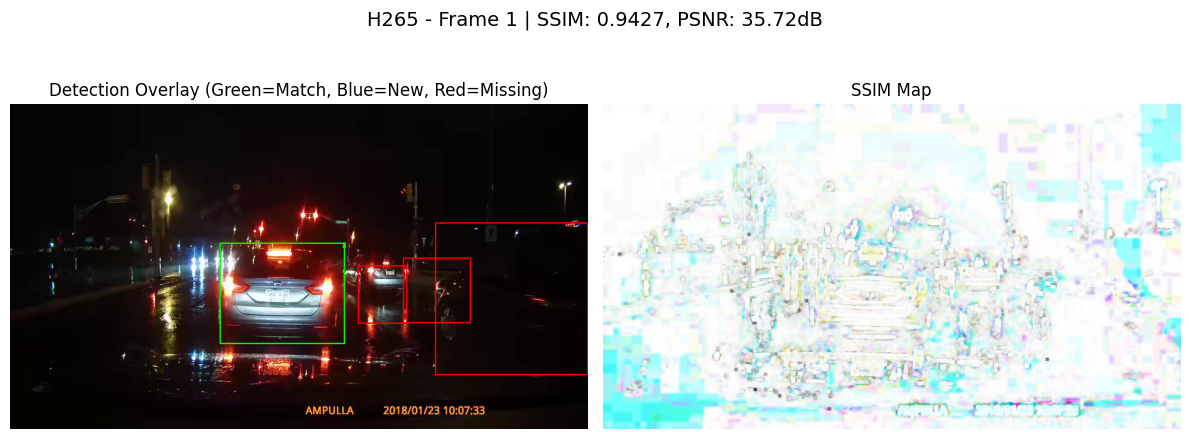

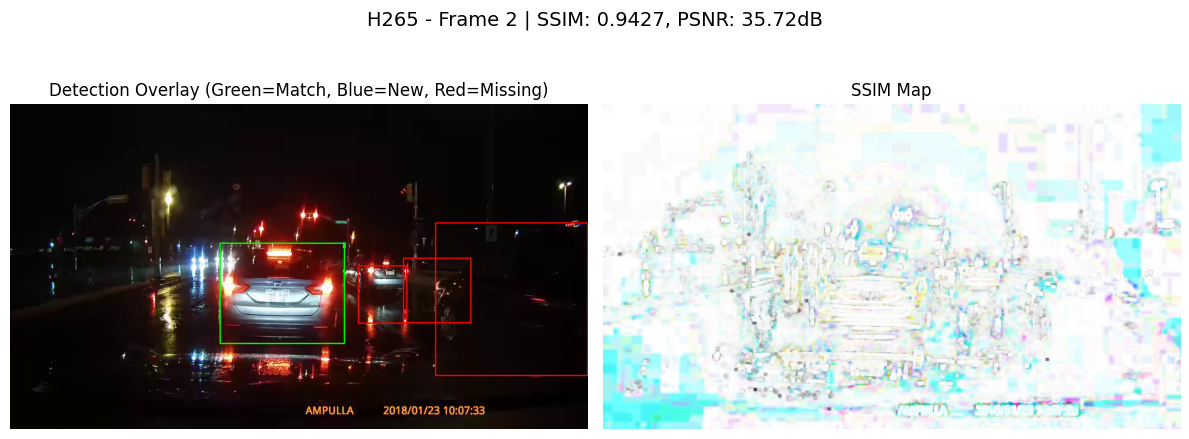

In [27]:
for codec in ["h264", "h265"]:
    print(f"\n=== Visualizations for {codec.upper()} ===")
    for idx in frames_to_show:
        data = results[codec][idx]

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(f"{codec.upper()} - Frame {data['frame']} | SSIM: {data['ssim']:.4f}, PSNR: {data['psnr']:.2f}dB", fontsize=14)

        axes[0].imshow(data["visual"])
        axes[0].set_title("Detection Overlay (Green=Match, Blue=New, Red=Missing)")
        axes[0].axis("off")

        axes[1].imshow(data["ssim_map"], cmap='gray')
        axes[1].set_title("SSIM Map")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()